# Load Boostvqe results from quantinuum

Following our example in the notebook `gci_boostvqe_circuit_synthesis.ipynb`, `quantinuum_execute_gci.ipynb` demonstrates how to submit the VQE and GCI circuits to the Qnexus platform and run with Quantinuum.
The results are stored in the  `results` folder.
This notebook shows how to retirevd the locally stored Qnexus job references and analyze the data.

## Load VQE and GCI circuits

In [1]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime
from quantinuum_utils import *

In [2]:
import os
os.chdir('..')
optimizer = 'sgd'
nqubits = 10
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ_step1.qasm'
gci_circ_file = folder_path + 'gci_circ_step1.qasm'

In [3]:
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
# render_circuit_jupyter(vqe_circ)

In [4]:
gci_circ = pytket.qasm.circuit_from_qasm(gci_circ_file)
# render_circuit_jupyter(gci_circ)

Let us check the size of the GCI circuit.

In [5]:
print("Circuit depth:", gci_circ.depth())
print("Circuit total gate count:", gci_circ.n_gates)
num_cnots = sum(1 for command in gci_circ if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)

Circuit depth: 127
Circuit total gate count: 940
Circuit CNOT count: 120


# Retrieve quantinuum results

Without running repeated jobs, we can retrieve our results from the Qnexus project.

In [6]:
qnx.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      BWIuaM                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://nexus.quantinuum.com/auth/device/browser?otp=BWIuaM0NDgZbbZPdcqLddipp7NDnk0Mq1hdavcMN2C6H2sjVawPVHlfOm8N4iuLDMvYBF-LNYenwdC7bUfqxaw
✅ Successfully logged in as xiaoyue.li@ntu.edu.sg using the browser.


In [7]:
optimisation_level = 2
folder_path = Path(f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_1VQE/')


# Initialize lists
gci_path_list = []
gci_noise_path_list = []
vqe_path_list = []
vqe_noise_path_list = []

for file in folder_path.iterdir():
    if file.is_file():
        name = file.stem  # Use .stem to exclude the file extension
        if name.startswith('execute_job_GCI_') and 'noise' not in name:
            gci_path_list.append(file.resolve())
        elif name.startswith('execute_job_GCI_') and 'noise' in name:
            gci_noise_path_list.append(file.resolve())
        elif name.startswith('execute_job_VQE_') and 'noise' not in name:
            vqe_path_list.append(file.resolve())
        elif name.startswith('execute_job_VQE_') and 'noise' in name:
            vqe_noise_path_list.append(file.resolve())

# verify list length
print('VQE noiseless job counts:', len(vqe_path_list))
print('VQE noise job counts:', len(vqe_noise_path_list))
print('GCI noiseless job counts:', len(gci_path_list))
print('GCI noise job counts:', len(gci_noise_path_list))

VQE noiseless job counts: 8
VQE noise job counts: 9
GCI noiseless job counts: 8
GCI noise job counts: 9


In [8]:
# load the job references
vqe_job_refs = job_ref_from_path_list(vqe_path_list)
vqe_noise_job_refs = job_ref_from_path_list(vqe_noise_path_list)
gci_job_refs = job_ref_from_path_list(gci_path_list)
gci_noise_job_refs = job_ref_from_path_list(gci_noise_path_list)

In [9]:
# load job results from job references
def load_job_results(job_refs):
    job_results = []
    for job_ref in job_refs:
        job_result = [job.download_result() for job in qnx.jobs.results(job_ref)]
        job_results.append(job_result)
    return job_results

In [10]:
vqe_job_results = load_job_results(vqe_job_refs)
vqe_noise_job_results = load_job_results(vqe_noise_job_refs)
gci_job_results = load_job_results(gci_job_refs)
gci_noise_job_results = load_job_results(gci_noise_job_refs)

# Prepare report

In [11]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# XXZ model
nqubits = 10
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)

In [13]:
qibo.set_backend("numpy")

[Qibo 0.2.13|INFO|2025-02-04 23:23:04]: Using numpy backend on /CPU:0


[Qibo 0.2.13|WARNING|2025-02-04 23:23:04]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


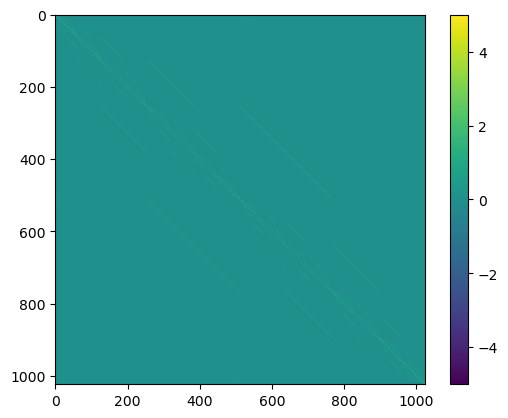

In [14]:
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

In [15]:
with open (vqe_circ_file, "r") as file:
    vqe_circuit_qasm_str = file.read()
    
with open (gci_circ_file, "r") as file:
    gci_circuit_qasm_str = file.read()

In [16]:
vqe_circ_qibo = qibo.models.Circuit.from_qasm(vqe_circuit_qasm_str)
gci_circ_qibo = qibo.models.Circuit.from_qasm(gci_circuit_qasm_str)

In [17]:
def compute_expectation_value_from_results(
    results: list[BackendResult],
    measurement_setup: MeasurementSetup,
    operator: QubitPauliOperator,
) -> float:
    '''
    This function loops with the measurement_setup corresponding to the
    hamiltonian, select the corresponding string_coef, results index and
    calculates the total expectation of the input hamiltonian.
    '''
    energy = 0
    for pauli_string, bitmaps in measurement_setup.results.items():
        string_coeff = operator.get(pauli_string, 0.0)
        # print('-----------------------------------')
        # print(pauli_string)
        if string_coeff != 0:
            for bm in bitmaps:
                index = bm.circ_index
                distribution = results[index].get_distribution()
                # print((distribution))
                value = compute_expectation_paulistring(distribution, bm)
                energy += complex(value * string_coeff).real
    return energy

In [18]:
def compute_expectation_paulistring(
    distribution: dict[tuple[int, ...], float], bitmap: MeasurementBitMap
) -> float:
    '''
    This function assumes that the bitmap is in the correct measurement basis
    and evaluates Pauli operators composed of Pauli.Z and Pauli.I.
    It calculates the expectation by counting the parity of the qubits being
    flipped.
    '''
    value = 0
    for bitstring, probability in distribution.items():
        # print(bitstring)
        # print(bitmap.bits)
        value += probability * (sum(bitstring[i] for i in bitmap.bits) % 2)
    return ((-1) ** bitmap.invert) * (-2 * value + 1)


In [19]:
vqe_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in vqe_job_results]

vqe_noise_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in vqe_noise_job_results]

gci_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in gci_job_results]

gci_noise_expvals = [compute_expectation_value_from_results(
    job_result, measurement_setup, ham_quantinuum
) for job_result in gci_noise_job_results]

In [20]:
report_quantinuum = report(vqe_circ_qibo, gci_circ_qibo, ham, 2000*2, vqe_expvals, gci_expvals, vqe_noise_expvals, gci_noise_expvals)

In [21]:
report_table(report_quantinuum)

,Analytical,Emulator,Emulator with Noise
VQE energy,-13.2122,-13.2019 ± 0.1050,-12.9274 ± 0.1259
GCI energy,-14.5051,-14.5634 ± 0.1099,-13.7124 ± 0.1184
Difference to target (VQE),2.0639,2.0743 ± 0.1050,2.3487 ± 0.1259
Difference to target (GCI),0.7710,0.7128 ± 0.1099,1.5637 ± 0.1184
Percentage difference to target (VQE),13.51%,13.58% ± 0.69%,15.38% ± 0.82%
Percentage difference to target (GCI),5.05%,4.67% ± 0.72%,10.24% ± 0.78%
Fidelity witness (VQE),-0.8975,-0.9071 ± 0.0965,-1.1594 ± 0.1158
Fidelity witness (GCI),0.2911,0.3447 ± 0.0965,-0.4377 ± 0.1089
